In [ ]:
import numpy as np

# --- Gaussian initialization ---
rng = np.random.default_rng(42)
n = 10000   # width
d = 10000     # input dimension

# Output vector:
a = rng.standard_normal(n) / np.sqrt(n)

# Initial data:
X = rng.standard_normal((n, d))   # each row x_i ~ N(0, I_d)

sigma2_W_0 = 1

# First-layer weight
W_0 = rng.standard_normal((d, n)) * np.sqrt(sigma2_W_0 / d)

# h^1(x_i) = x_i W_0
x_i = X[0]
h1 = x_i @ W_0 

#define RuLu
x1_sigma = np.maximum(0, h1)

#Save h vectors
h_vectors = [h1, x1_sigma]

# Define how we sample Z's according to our analytically found dists
def sample_Zs(n_samples, rng=None):
    rng = rng or np.random.default_rng()
    z_h1 = rng.standard_normal(n_samples) * np.sqrt(sigma2_W_0)
    # Z^{x^1_σ} ~ rectified Gaussian: 1/2 at 0, 1/2 half-normal
    half_normal = np.abs(rng.standard_normal(n_samples)) * np.sqrt(sigma2_W_0)
    z_x1_sigma = np.where(rng.random(n_samples) < 0.5, 0.0, half_normal)
    return np.column_stack([z_h1, z_x1_sigma])

In [ ]:
def master_theorem_check(h_vectors, sample_Zs, psi_list, n_Z_samples=50_000):
    Z_samples = sample_Zs(n_Z_samples)
    k = Z_samples.shape[1]
    results = []
    for name, psi in psi_list:
        rhs = np.mean([psi(*Z_samples[i]) for i in range(n_Z_samples)])
        if h_vectors is not None and len(h_vectors) == k:
            n = len(h_vectors[0])
            lhs = (1 / n) * sum(psi(*(h_vectors[j][α] for j in range(k))) for α in range(n))
            results.append((name, lhs, rhs, np.isclose(lhs, rhs, atol=0.05)))
        else:
            results.append((name, None, rhs, None))
    return results

# Define ψ functions (need to be polynomially bounded)
def psi_x2(*xs):
    return xs[0] ** 2

def psi_sqrt(*xs):
    return np.sqrt(xs[0]**2)

def psi_log(*xs):
    return np.log(1 + xs[0]**2)

psi_list = [
    ("h^1 E[x^2]", psi_x2),
    ("h^1 E[sqrt(x²+ε)]", psi_sqrt),
    ("h^1 E[log(1+x²)]", psi_log),
    ("x^1_σ E[x^2]", lambda *xs: xs[1]**2),
    ("x^1_σ E[sqrt(x²+ε)]", lambda *xs: np.sqrt(xs[1]**2 + 1e-10)),
    ("x^1_σ E[log(1+x²)]", lambda *xs: np.log(1 + xs[1]**2)),
]

out = master_theorem_check(h_vectors, sample_Zs, psi_list)

#print results
for name, lhs, rhs, ok in out:
    print(f"{name}:  LHS={lhs:.6f}  RHS={rhs:.6f}  ok={ok}")

h^1 E[x^2]:  LHS=0.995533  RHS=1.005464  ok=True
h^1 E[sqrt(x²+ε)]:  LHS=0.794388  RHS=0.799731  ok=True
h^1 E[log(1+x²)]:  LHS=0.530318  RHS=0.535128  ok=True
x^1_σ E[x^2]:  LHS=0.489891  RHS=0.500992  ok=True
x^1_σ E[sqrt(x²+ε)]:  LHS=0.394264  RHS=0.399446  ok=True
x^1_σ E[log(1+x²)]:  LHS=0.262534  RHS=0.267277  ok=True


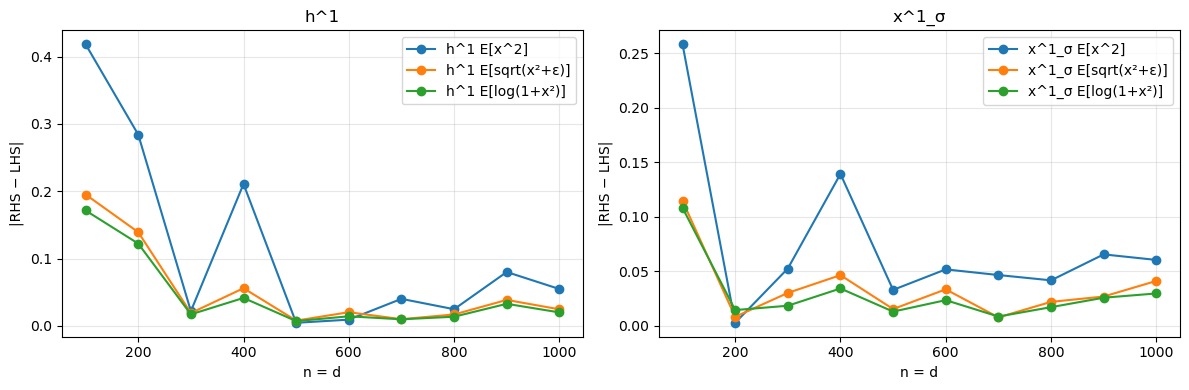

In [3]:
import matplotlib.pyplot as plt

sizes = np.arange(100, 1100, 100)
rng_scan = np.random.default_rng(42)
errors_by_psi = {name: [] for name, _ in psi_list}
for n_d in sizes:
    n, d = n_d, n_d
    X = rng_scan.standard_normal((n, d))
    W_0 = rng_scan.standard_normal((d, n)) * np.sqrt(sigma2_W_0 / d)
    h1 = (X[0] @ W_0)
    x1_sigma = np.maximum(0, h1)
    h_vectors_n = [h1, x1_sigma]
    out = master_theorem_check(h_vectors_n, sample_Zs, psi_list)
    for (name, _), (_, lhs, rhs, _) in zip(psi_list, out):
        if lhs is not None:
            errors_by_psi[name].append(np.abs(rhs - lhs))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for name in errors_by_psi:
    if name.startswith("h^1"):
        ax1.plot(sizes, errors_by_psi[name], "o-", label=name)
    else:
        ax2.plot(sizes, errors_by_psi[name], "o-", label=name)
ax1.set_xlabel("n = d")
ax1.set_ylabel("|RHS − LHS|")
ax1.set_title("h^1")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.set_xlabel("n = d")
ax2.set_ylabel("|RHS − LHS|")
ax2.set_title("x^1_σ")
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()